In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf

### Pitch tracks

In [2]:
# Function to extract pitch track and display spectrogram
def getAndDisplayPitchTrack(file_path):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None, mono=True)

    # Compute the pitch track using librosa's YIN algorithm
    f0 = librosa.yin(audio, fmin=10, fmax=400)

    fig, ax = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

    # Plot the spectrogram
    S = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    spec = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax = ax[0])
    # cbar = fig.colorbar(spec, ax=ax[0], format='%+2.0f dB')
    ax[0].set_title('Spectrogram')
    ax[0].set_xlabel('')

    # Plot the pitch track
    times = librosa.times_like(f0, sr=sr)
    ax[1].plot(times, f0, label='Pitch Track (f0)', color='r')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Frequency (Hz)')
    ax[1].set_title('Pitch Track')

    ax[1].set_xlim(ax[0].get_xlim())
    
    # plt.tight_layout(rect=[0, 0, 0.95, 1])
    
    plt.show()

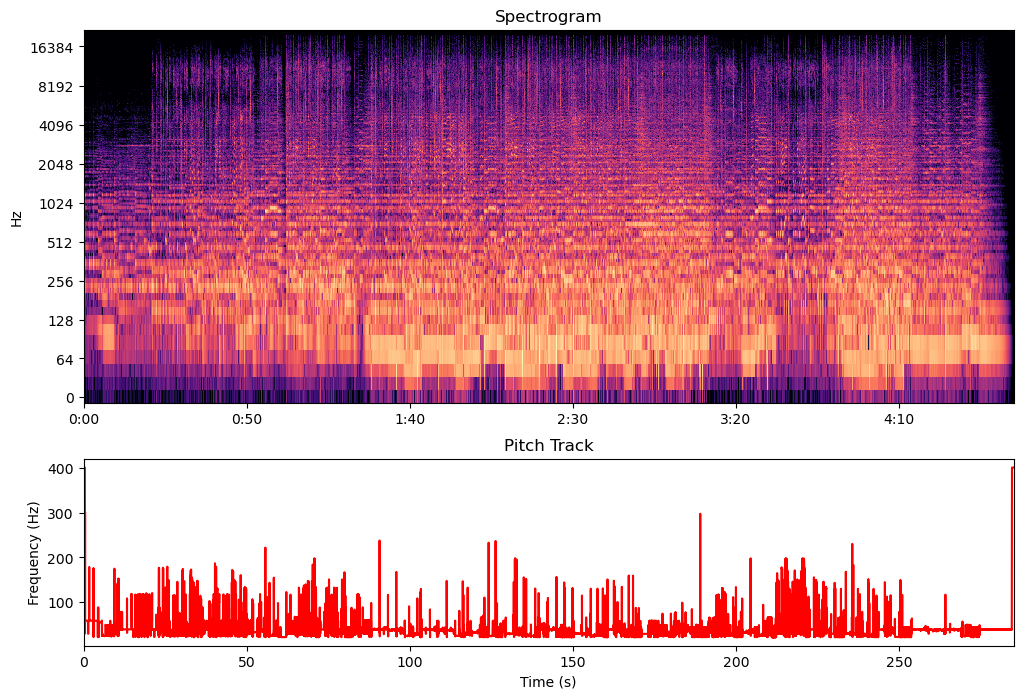

In [3]:
file_path_full = 'full_track.mp3'
getAndDisplayPitchTrack(file_path_full)

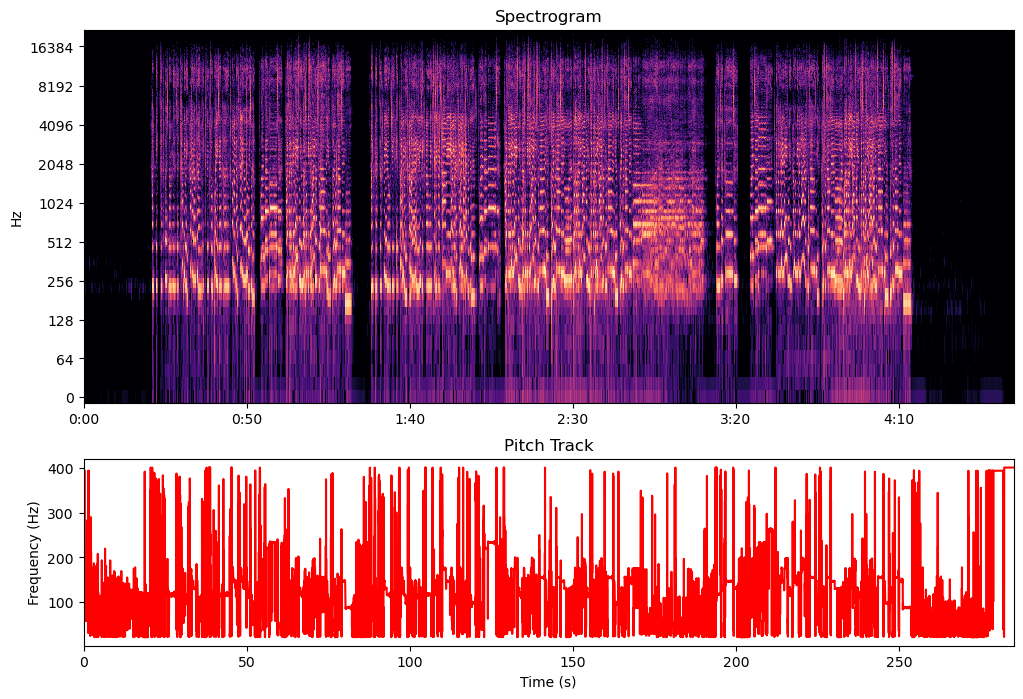

In [4]:
file_path_vocals = 'vocal_track.mp3'  
getAndDisplayPitchTrack(file_path_vocals)

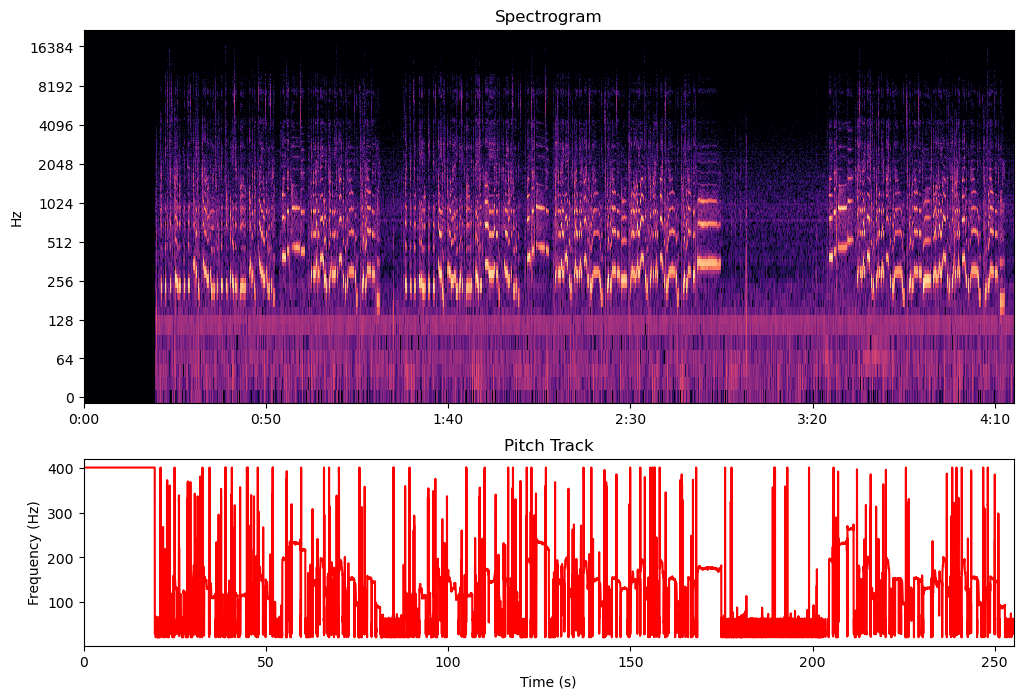

In [5]:
file_path_vocals_karaoke = 'karaoke_vocal_track.mp3'  
getAndDisplayPitchTrack(file_path_vocals_karaoke)

### MFCCs
https://musicinformationretrieval.com/mfcc.html

In [3]:
file_path_full = 'full_track.mp3'
file_path_vocals = 'vocal_track.mp3'  
file_path_vocals_karaoke = 'karaoke_vocal_track.mp3'  

# Parameters
sr = 44100
window_size = int(0.032 * sr)  # 32 ms window
hop_length = int(0.008 * sr)   # 8 ms hop length
n_mfcc = 20  # Number of MFCCs to extract

full_audio, full_sr = librosa.load(file_path_full, sr=sr, mono=True)
vocals_audio, vocals_sr = librosa.load(file_path_vocals, sr=sr, mono=True)
vocals_karaoke_audio, vocals_karaoke_sr = librosa.load(file_path_vocals_karaoke, sr=sr, mono=True)

# Compute MFCCs
mfcc_full = librosa.feature.mfcc(y=full_audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=window_size)
mfcc_vocals = librosa.feature.mfcc(y=vocals_audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=window_size)
mfcc_vocals_karaoke = librosa.feature.mfcc(y=vocals_karaoke_audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=window_size)

# (Number of MFCC Coefficients, Number of Frames)
print("MFCC Full Shape: ", mfcc_full.shape)
print("MFCC Vocals Shape: ", mfcc_vocals.shape)
print("MFCC Vocals Karaoke Shape: ", mfcc_vocals_karaoke.shape)

MFCC Full Shape:  (20, 35721)
MFCC Vocals Shape:  (20, 35721)
MFCC Vocals Karaoke Shape:  (20, 31973)


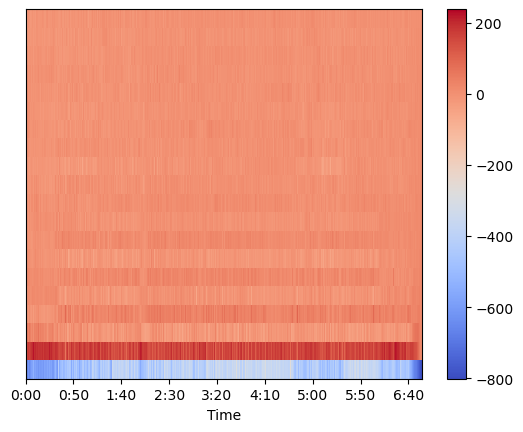

In [4]:
librosa.display.specshow(mfcc_full, sr=sr, x_axis='time')
plt.colorbar()

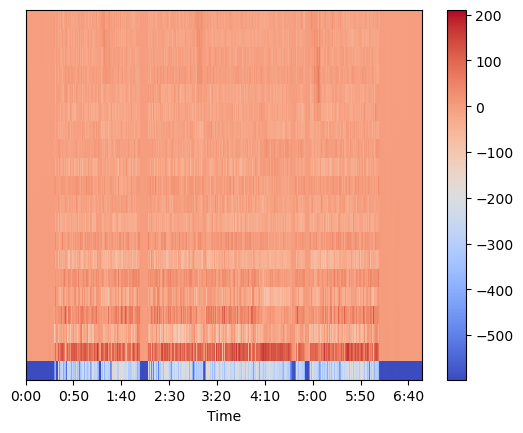

In [5]:
librosa.display.specshow(mfcc_vocals, sr=sr, x_axis='time')
plt.colorbar()

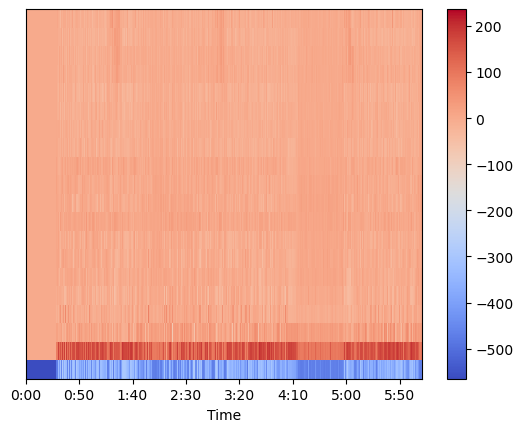

In [6]:
librosa.display.specshow(mfcc_vocals_karaoke, sr=sr, x_axis='time')
plt.colorbar()

### Dynamic time warping
https://www.youtube.com/playlist?list=PLmZlBIcArwhMJoGk5zpiRlkaHUqy5dLzL

In [14]:
import numpy as np
from scipy.spatial.distance import cdist

def dp(dist_mat):
    """
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape
    
    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)

def compute_dtw(mfcc1, mfcc2):
    """
    Compute Dynamic Time Warping (DTW) between two MFCC matrices.

    Parameters:
    - mfcc1: np.array, shape (n_mfcc, n_frames1) - MFCC matrix for vocals
    - mfcc2: np.array, shape (n_mfcc, n_frames2) - MFCC matrix for vocals_karaoke

    Returns:
    - path: List of indices indicating the minimum-cost path
    - cost_matrix: The accumulated cost matrix
    """

    # Compute pairwise Euclidean distance matrix between MFCC frames
    dist_matrix = cdist(mfcc1.T, mfcc2.T, metric='euclidean')

    # Use dynamic programming function to find optimal path
    path, cost_matrix = dp(dist_matrix)

    return path, cost_matrix


In [ ]:
path, cost_matrix = compute_dtw(mfcc_vocals, mfcc_vocals_karaoke)

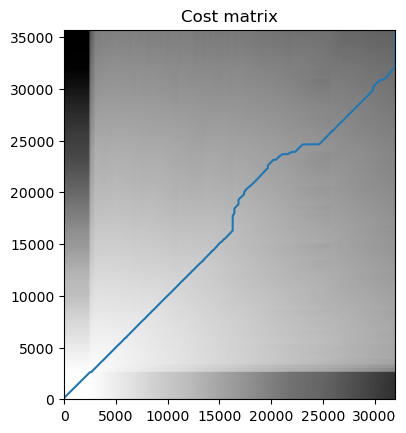

In [ ]:
plt.title("Cost matrix")
plt.imshow(cost_matrix, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path)

In [27]:
import pickle
with open('cost_matrix.pkl', 'wb') as file:
    pickle.dump(cost_matrix, file)

with open('path.pkl', 'wb') as file:
    pickle.dump(path, file)

In [7]:
import pickle
import numpy as np
loaded_cost_matrix = None
loaded_path = None

with open('cost_matrix.pkl', 'rb') as file:
    loaded_cost_matrix = pickle.load(file)
with open('path.pkl', 'rb') as file:
    loaded_path = pickle.load(file)

print(np.shape(loaded_cost_matrix))
print(np.shape(loaded_path))

(35721, 31973)
(40200, 2)


In [22]:
print(mfcc_vocals.shape)
print(mfcc_vocals_karaoke.shape)

(20, 35721)
(20, 31973)


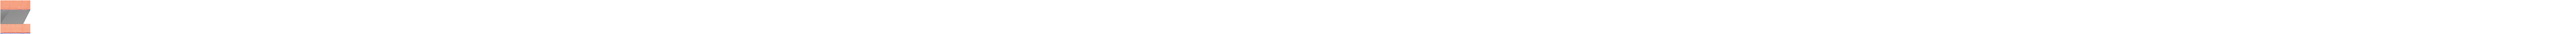

In [ ]:
from matplotlib.patches import ConnectionPatch

fig = plt.figure(figsize=(9, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)
ax1.axis("off")
ax2.axis("off")
img = librosa.display.specshow(mfcc_vocals, x_axis='time', ax=ax1, sr=sr)
img = librosa.display.specshow(mfcc_vocals_karaoke, x_axis='time', ax=ax2, sr=sr)

for x_i, y_j in loaded_path:
    con = ConnectionPatch(
        xyA=(x_i, 0), xyB=(y_j, mfcc_vocals.shape[0] - 1), coordsA="data", coordsB="data",
        axesA=ax1, axesB=ax2, color="C7"
        )
    ax2.add_artist(con)

In [6]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
import pandas as pd

file_path_full_short = 'full_track_short_1.mp3'
file_path_vocals_short = 'vocal_track_short_1.mp3'  
file_path_vocals_nmf_short = 'vocals_21s_rec.wav'
file_path_vocals_nmf_is_short = 'vocals_21s_rec_is.wav'
file_path_vocals_karaoke_short = 'karaoke_vocal_track_short_1.mp3'  

# Parameters
sr = 44100
window_size = int(0.032 * sr)  # 32 ms window
hop_length = int(0.008 * sr)   # 8 ms hop length
n_mfcc = 13  # Number of MFCCs to extract

full_audio_short, full_sr = librosa.load(file_path_full_short, sr=sr, mono=True)
vocals_audio_short, vocals_sr = librosa.load(file_path_vocals_short, sr=sr, mono=True)
vocals_nmf_audio_short, vocals_nmf_sr = librosa.load(file_path_vocals_nmf_short, sr=sr, mono=True)
vocals_nmf_is_audio_short, vocals_nmf_is_sr = librosa.load(file_path_vocals_nmf_is_short, sr=sr, mono=True)
vocals_karaoke_audio_short, vocals_karaoke_sr = librosa.load(file_path_vocals_karaoke_short, sr=sr, mono=True)

# Compute MFCCs
mfcc_full_short = librosa.feature.mfcc(y=full_audio_short, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=window_size)
mfcc_vocals_short = librosa.feature.mfcc(y=vocals_audio_short, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=window_size)
mfcc_vocals_nmf_short = librosa.feature.mfcc(y=vocals_nmf_audio_short, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=window_size)
mfcc_vocals_nmf_is_short = librosa.feature.mfcc(y=vocals_nmf_is_audio_short, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=window_size)
mfcc_vocals_karaoke_short = librosa.feature.mfcc(y=vocals_karaoke_audio_short, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=window_size)

# (Number of MFCC Coefficients, Number of Frames)
print("MFCC Full Shape: ", mfcc_full_short.shape)
print("MFCC Vocals Shape: ", mfcc_vocals_short.shape)
print("MFCC Vocals NMF Shape: ", mfcc_vocals_nmf_short.shape)
print("MFCC Vocals NMF IS Shape: ", mfcc_vocals_nmf_is_short.shape)
print("MFCC Vocals Karaoke Shape: ", mfcc_vocals_karaoke_short.shape)

MFCC Full Shape:  (13, 2721)
MFCC Vocals Shape:  (13, 2721)
MFCC Vocals NMF Shape:  (13, 2721)
MFCC Vocals NMF IS Shape:  (13, 2721)
MFCC Vocals Karaoke Shape:  (13, 2721)


In [93]:
import numpy as np

def cosine_similarity_matrices(matrix1, matrix2):
    """
    Calculate the cosine similarity between corresponding rows of two matrices.

    Parameters:
        matrix1 (numpy.ndarray): First matrix (n x m).
        matrix2 (numpy.ndarray): Second matrix (n x m), must have the same shape as matrix1.

    Returns:
        numpy.ndarray: A 1D array of cosine similarities for each row in the matrices.
    """
    # Check if the matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Both matrices must have the same shape.")
   
    # Calculate the dot product of corresponding rows
    dot_product = np.sum(matrix1 * matrix2, axis=1)
   
    # Calculate the L2 norms (magnitudes) of the rows in each matrix
    norm1 = np.linalg.norm(matrix1, axis=1)
    norm2 = np.linalg.norm(matrix2, axis=1)
   
    # Calculate cosine similarity for each row
    cosine_similarities = dot_product / (norm1 * norm2)
   
    # Replace NaN values with 0 (in case of zero vectors)
    cosine_similarities = np.nan_to_num(cosine_similarities)
   
    return cosine_similarities

In [94]:
kl_and_orig = cosine_similarity_matrices(mfcc_vocals_nmf_short, mfcc_vocals_short)

In [95]:
is_and_orig = cosine_similarity_matrices(mfcc_vocals_nmf_is_short, mfcc_vocals_short)

In [96]:
kl_and_is = cosine_similarity_matrices(mfcc_vocals_nmf_short, mfcc_vocals_nmf_is_short)

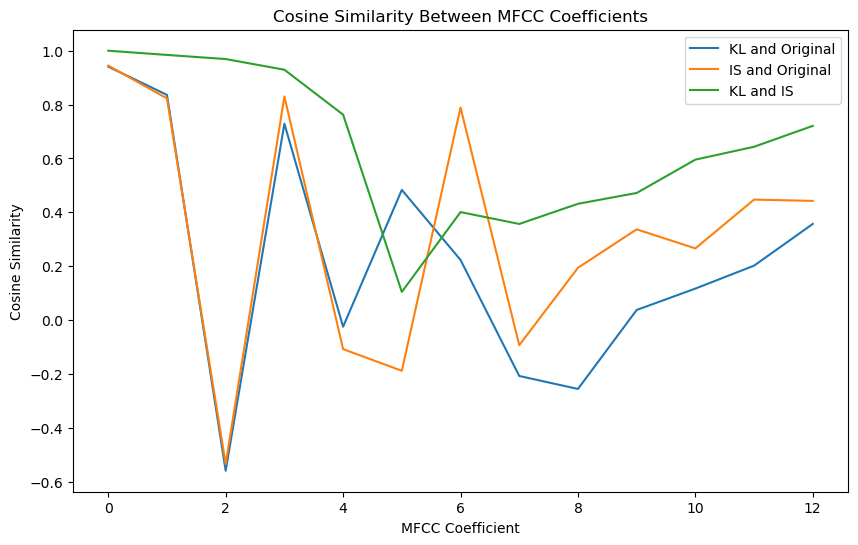

In [97]:
# Create a plot of cosine similarities for each MFCC coefficient for kl_and_orig, is_and_orig, and kl_and_is
plt.figure(figsize=(10, 6))
plt.plot(kl_and_orig, label="KL and Original")
plt.plot(is_and_orig, label="IS and Original")
plt.plot(kl_and_is, label="KL and IS")
plt.xlabel("MFCC Coefficient")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity Between MFCC Coefficients")
plt.legend()
plt.show()

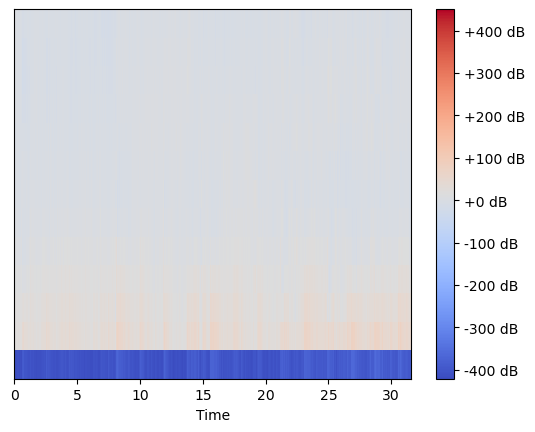

In [7]:
librosa.display.specshow(mfcc_vocals_nmf_short, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')

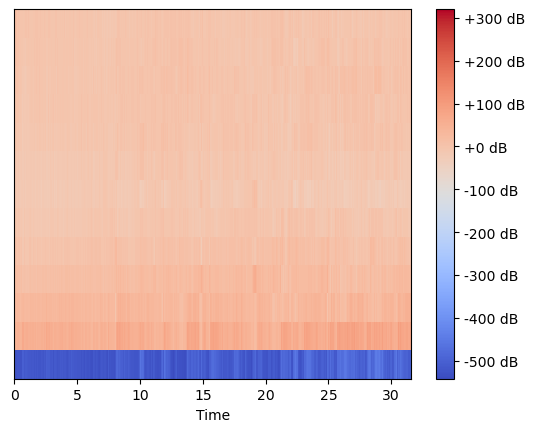

In [8]:
librosa.display.specshow(mfcc_vocals_nmf_is_short, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')

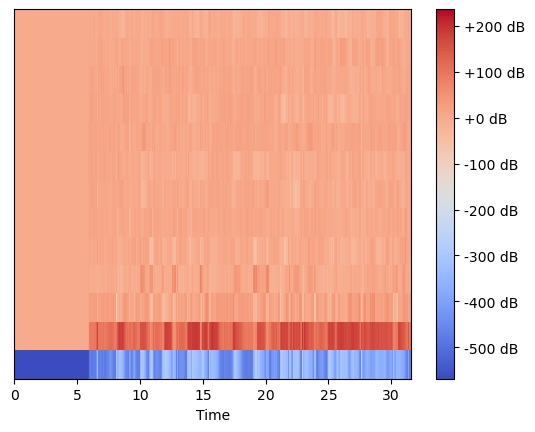

In [12]:
librosa.display.specshow(mfcc_vocals_karaoke_short, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')

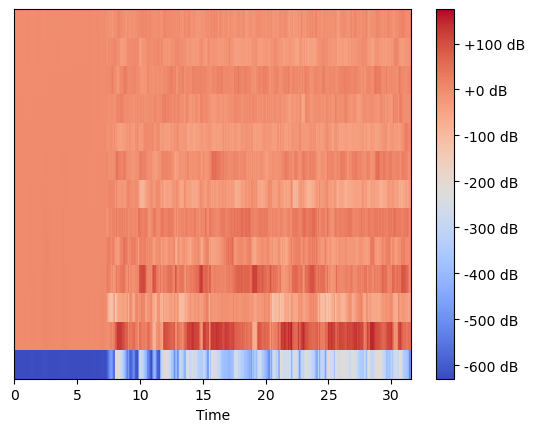

In [11]:
librosa.display.specshow(mfcc_vocals_short, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')

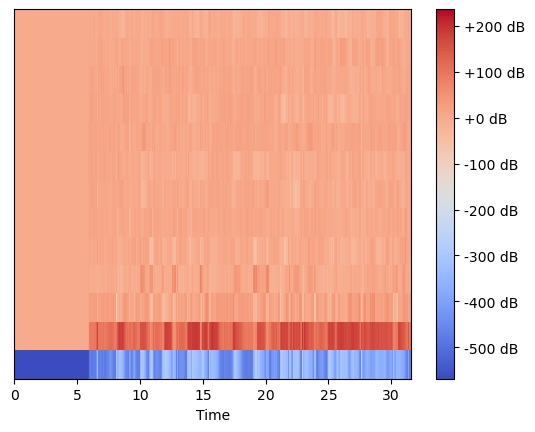

In [10]:
librosa.display.specshow(mfcc_vocals_karaoke_short, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')

In [15]:
path_short, cost_matrix_short = compute_dtw(mfcc_vocals_nmf_is_short, mfcc_vocals_short)

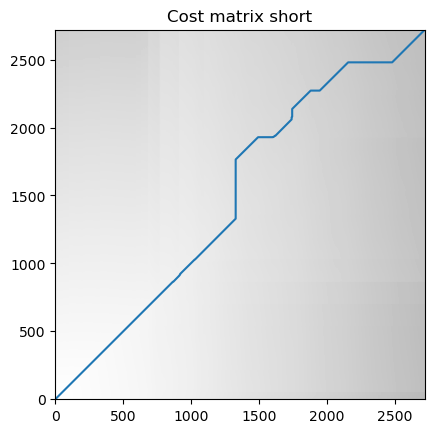

In [69]:
plt.title("Cost matrix short")
plt.imshow(cost_matrix_short, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path_short)
plt.plot(y_path, x_path)

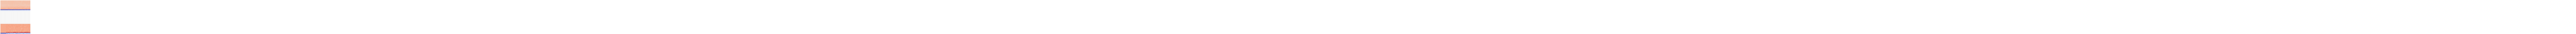

In [ ]:
from matplotlib.patches import ConnectionPatch

fig = plt.figure(figsize=(9, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)

img = librosa.display.specshow(mfcc_vocals_nmf_is_short, x_axis='time', ax=ax1, sr=sr)
img = librosa.display.specshow(mfcc_vocals_karaoke_short, x_axis='time', ax=ax2, sr=sr)

# ax1.imshow(mfcc_vocals, origin="lower", interpolation="nearest")
# ax2.imshow(mfcc_vocals_karaoke, origin="lower", interpolation="nearest")
ax1.axis("off")
ax2.axis("off")

for x_i, y_j in path_short:
    con = ConnectionPatch(
        xyA=(x_i, 0), xyB=(y_j, mfcc_vocals_nmf_is_short.shape[0] - 1), coordsA="data", coordsB="data",
        axesA=ax1, axesB=ax2, color="C7"
        )
    ax2.add_artist(con)